# Tutorial 5: Visualizing Learning

In the previous tutorial we have seen how to train an agent, but I bet that everyone of us has thought at least once "Is it really learning anything?". In this tutorial we will try to answer to that question.

We gathered again all the functions written in the previous tutorial in a script ship.py, that you can find in the Modules folder. 

## Outline
1. Online visualization: how to see how the training is doing while the agent is still training.
2. Rendering: how to visualize the agent moving during one episode.
2. Post-training visualization: how to look at the final result.

In [2]:
#import modules and libraries
import sys
sys.path.insert(0, "../Environment/")
sys.path.insert(0, "../Modules/")
import halite_env as Env
import encode as cod
import ship 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time #used for time.sleep()

We redifine all variables and constants as in the previous tutorial

In [4]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
H_LEV = 3 # halite levels
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*H_LEV**6*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 30 #100 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01
LEARNING_RATE = 0.1
EPS_START = 0.5

Total number of states to be experienced:  142884


In [5]:
# convert all the parameters to dictionaries
env_dict = dict(NUM_PLAYERS = NUM_PLAYERS , 
                TOT_TURNS = TOT_TURNS)

state_dict = dict(MAP_SIZE = MAP_SIZE,  
                  H_LEV = H_LEV, 
                  N_ACTIONS = N_ACTIONS)

learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = EPS_START, 
                     STD_REWARD = STD_REWARD)

In [9]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained

## 1 - Online visualization

The online visualization is based on two ideas: to find some metrics to monitor and to monitor them almost in real time.

One of the obvious metrics that we measured in the previous tutorial was the return at the end of the episode.
Another one directly connected to that, but with a more practical touch, is the halite collected from the agent during the episode.

And finally we would like to know how many time the ship passes through the shipyard, since it is a good indicator of what is going on.

Thus we now modify the play_episode function written in the previous tutorial in order to make it compute those quantities.

In [6]:
def play_episode(q_values, eps, NUM_PLAYERS, MAP_SIZE, TOT_TURNS, N_ACTIONS, H_LEV,
                 STD_REWARD,LEARNING_RATE, DISCOUNT_FACTOR, verbose = False):
    """
    Trains the agent by playing one episode of halite.
    
    Parameters
    ----------
    q_values         : numpy array 
        Contains the Q-values
    eps              : float 
        Represents a probability, must be in [0,1], controls the probability of exploring instead of exploting
    NUM_PLAYERS      : int
    MAP_SIZE         : int
    TOT_TURNS        : int
    N_ACTIONS        : int
    H_LEV            : int
    STD_REWARD       : float
        Baseline reward given to the agent when does not deposit halite to the shipyard
    LEARNING_RATE    : float
    DISCOUNT_FACTOR  : float
        Must be greater than 0 but smaller than 1. Suggested 1-1/TOT_TURNS or 1
    verbose          : bool
        Prints halite of the player at each turn of the game
        
    Returns
    -------
    q_values         : numpy array 
        Updated Q-values
    reward           : float
        Reward obtained in this episode. 
    collected_halite : float
        Halite collected by the agent.
    passages         : int
        Number of passages of the ship through the shipyard.
    """
    env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
    steps = 0
    reward = 0 # cumulative reward of the episode
    passages = 0 # number of times the ship passes through the shipyard
    
    # first mandatory step
    steps = steps + 1
    if verbose:
        print("\nStep number %d:"%steps)
    action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
    shipyard_action = True # initially always choose to create a ship
    # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
    state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
    #print("Cargo layer: \n", state[:,:,2])
    current_halite = players_halite[0][0]
    s_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)

    while True:
        steps = steps + 1
        if verbose:
            print("\nStep number %d:"%steps)
            print("Current halite: ", current_halite)
        a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
        a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form

        # submit the action and get the new state
        state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

        new_halite = players_halite[0][0]

        # compute the 1-ship reward as the halite increment of the player divided by the max halite 
        # plus a standard negative reward 
        r = (new_halite - current_halite)/1000 + STD_REWARD

        sp_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
        reward += r # cumulative reward of the episode

        # adds 1 to passages if the current position of the ship coincides with that of the shipyard
        # whereas the previous position didn't
        s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
        if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
            passages = passages +1
                
        a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

        # update Q-values
        q_values = ship.update_q_v1(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, alpha = LEARNING_RATE,
                    gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS)

        # update states and halite
        s_enc = sp_enc
        current_halite = new_halite

        if (finish == True) or (steps >= 400):
            if verbose:
                print("\nEnd episode.")
            break
    collected_halite = current_halite - 4000
    return q_values, reward, collected_halite, passages

To skip a passage I already copied this function in the ship.py script in the Modules folder.

In [7]:
q_values, reward, collected_halite, passages = ship.play_episode(q_values, verbose = True, **env_dict, **state_dict, **learning_dict)


Step number 1:

Step number 2:
Current halite:  4000.0

Step number 3:
Current halite:  4000.0

Step number 4:
Current halite:  4000.0

Step number 5:
Current halite:  4000.0

Step number 6:
Current halite:  4000.0

Step number 7:
Current halite:  4000.0

Step number 8:
Current halite:  4000.0

Step number 9:
Current halite:  4000.0

Step number 10:
Current halite:  4000.0

Step number 11:
Current halite:  4000.0

Step number 12:
Current halite:  4000.0

Step number 13:
Current halite:  4000.0

Step number 14:
Current halite:  4000.0

Step number 15:
Current halite:  4000.0

Step number 16:
Current halite:  4000.0

Step number 17:
Current halite:  4000.0

Step number 18:
Current halite:  4000.0

Step number 19:
Current halite:  4000.0

Step number 20:
Current halite:  4000.0

Step number 21:
Current halite:  4000.0

Step number 22:
Current halite:  4000.0

Step number 23:
Current halite:  4000.0

Step number 24:
Current halite:  4000.0

Step number 25:
Current halite:  4000.0

Step nu


Step number 209:
Current halite:  7746.0

Step number 210:
Current halite:  7746.0

Step number 211:
Current halite:  7746.0

Step number 212:
Current halite:  7746.0

Step number 213:
Current halite:  7746.0

Step number 214:
Current halite:  7746.0

Step number 215:
Current halite:  7746.0

Step number 216:
Current halite:  7746.0

Step number 217:
Current halite:  7746.0

Step number 218:
Current halite:  7746.0

Step number 219:
Current halite:  8746.0

Step number 220:
Current halite:  8746.0

Step number 221:
Current halite:  8746.0

Step number 222:
Current halite:  8746.0

Step number 223:
Current halite:  8746.0

Step number 224:
Current halite:  8746.0

Step number 225:
Current halite:  8746.0

Step number 226:
Current halite:  8746.0

Step number 227:
Current halite:  9217.0

Step number 228:
Current halite:  9217.0

Step number 229:
Current halite:  9217.0

Step number 230:
Current halite:  9217.0

Step number 231:
Current halite:  9217.0

Step number 232:
Current halite: 

In [8]:
print("Reward: %.4f \nCollected halite : %.0f \nPassages through shipyard: %d"%(reward, collected_halite, passages))

Reward: 2.8360 
Collected halite : 6826 
Passages through shipyard: 12


Now we want to plot this quantities in real time during the training.

<IPython.core.display.Javascript object>


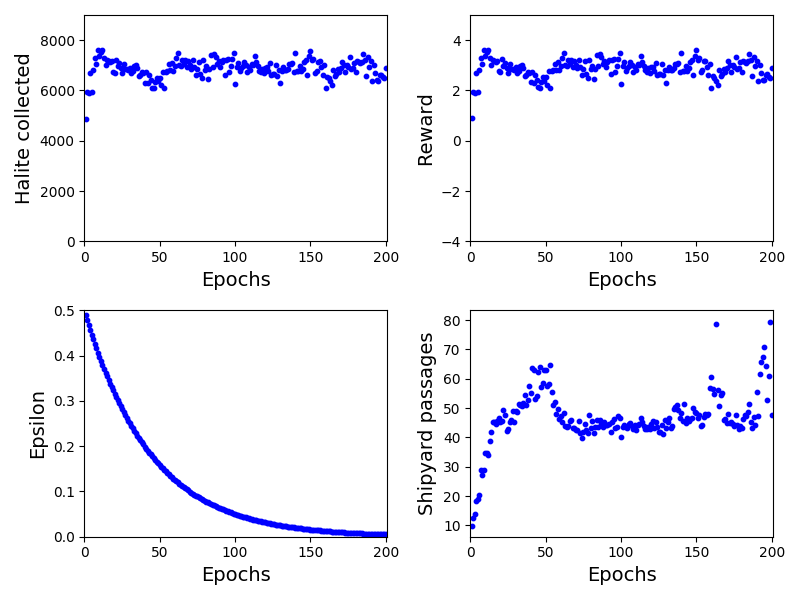

Hey, I think you've had enough! Let's stop here.


In [10]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(MAX_EPOCHS)
halite_score = np.zeros(MAX_EPOCHS)
shipy_pass = np.zeros(MAX_EPOCHS)
epochs = 0
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))


# visualize online the results
%matplotlib notebook
fig = plt.figure(figsize = (8,6))
plt.ion()

ax1 = fig.add_subplot(221)
ax1.set_xlim(0,MAX_EPOCHS+1)
ax1.set_ylim(0,9000)
ax1.set_xlabel("Epochs", fontsize = 14)
ax1.set_ylabel("Halite collected", fontsize = 14)

ax2 = fig.add_subplot(222)
ax2.set_xlim(0,MAX_EPOCHS+1)
ax2.set_ylim(-4,5)
ax2.set_xlabel("Epochs", fontsize = 14)
ax2.set_ylabel("Reward", fontsize = 14)


ax3 = fig.add_subplot(223)
ax3.set_xlim(0,MAX_EPOCHS+1)
ax3.set_ylim(0,0.5)
ax3.set_xlabel("Epochs", fontsize = 14)
ax3.set_ylabel("Epsilon", fontsize = 14)


ax4 = fig.add_subplot(224)
ax4.set_xlim(0,MAX_EPOCHS+1)
ax4.set_xlabel("Epochs", fontsize = 14)
ax4.set_ylabel("Shipyard passages", fontsize = 14)

plt.tight_layout()
fig.show()
fig.canvas.draw()

from tqdm import tnrange, trange

for k in tnrange(MAX_EPOCHS, desc='1st loop', leave=True):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    shipy_pass_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    eps = epsilons[epochs]
    # update the dictionary at each epoch with the new epsilon
    learning_dict = dict(LEARNING_RATE = 0.1, DISCOUNT_FACTOR = DISCOUNT_FACTOR , eps = eps, STD_REWARD = STD_REWARD)

    for i in tnrange(N_BATCH, desc='2nd loop', leave=False):
        # here starts an episode
        q_values, reward, collected_halite, passages = play_episode(q_values, **env_dict, **state_dict, **learning_dict)
        reward_progress[i] = reward
        halite_progress[i] = collected_halite
        shipy_pass_progress[i] = passages

        #break # play just 1 episode

    #break # play just 1 epoch

    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()
    shipy_pass[epochs-1] = shipy_pass_progress.mean()
    
    ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
    ax2.scatter(epochs, reward_score[epochs-1], s = 10,color='blue')
    ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
    ax4.scatter(epochs, shipy_pass[epochs-1], s = 10, color='blue')
    fig.canvas.draw()

    if epochs >= MAX_EPOCHS:
        print("Hey, I think you've had enough! Let's stop here.")
        break

In [13]:
np.save('Q_values/q_val_30batch', q_values)

## 2 - Rendering

In this section we try to render an entire episode for a given state of the Q-values, considering them as definitive. The idea is to color the sea with a blue tonality that becomes brighter as the halite in the cell increases and to color the ship with some brown to yellow tonality, again with the brighter colors for the richest states. Also between one frame and the other, we show in a scale between red and green the Q-values for the adjacent cells, so that we can see why a certain action has been taken.

We do not enter into the details of how this visualization is done, but the code is all here below.

In [6]:
q_values = np.load("Q_values/Q_values.npy")

In [7]:
# some functions to represent in RGB the halite levels of the map and the ship

def color_sea(map_halite):
    #color1 = np.array([32,124,157])
    sea_colors = np.zeros((1001,3))
    for i in range(1001):
        sea_colors[i] = [32,20+i/10,50+2*i/10]
    N = len(map_halite.flatten())
    rgb_map = np.zeros((N,3))
    flatten_map = map_halite.flatten()
    for i in range(N):
        rgb_map[i] = sea_colors[int(flatten_map[i])]
    return rgb_map.reshape((map_halite.shape)+(3,))/255

def color_ship(cargo):
    #color2 = np.array([255,203,119])
    ship_colors = np.zeros((1001,3))
    for i in range(1001):
        ship_colors[i] = [(120+2*i/10)*250/320,(70+2*i/10)*200/270,(90+i/10)*120/210]
    return ship_colors[int(cargo)]/255    

def decision_map(q_s, x, y, rgb_map, map_size = 7, alpha=0.5):
    
    def Q_to_color(q_array):
        x = (q_array-q_array.min()+ 1e-5)/(q_array.max() - q_array.min() + 1e-5)
        color = np.array([[225*(1-xi),225*xi,25] for xi in x])/255
        return color
    
    pos_dict = {0:(0,0), 1:(1,0), 2:(-1,0), 3:(0,1), 4:(0,-1)}
    q_colors = Q_to_color(q_s)
    pos_dec = (x,y)
    for i in range(5):
        xi = (pos_dec[0]+pos_dict[i][0])%map_size
        yi = (pos_dec[1]+pos_dict[i][1])%map_size
        rgb_map[xi,yi] = alpha*q_colors[i]+(1-alpha)*rgb_map[xi,yi]
    return rgb_map

<IPython.core.display.Javascript object>


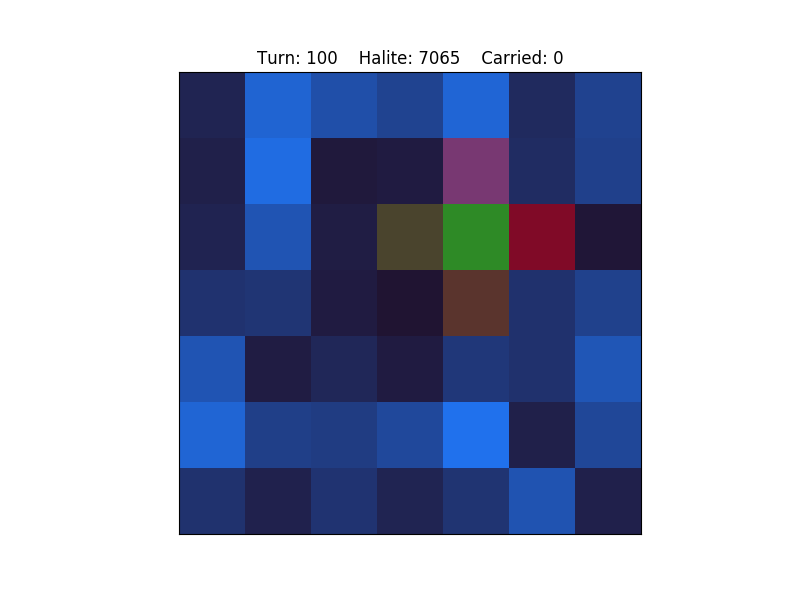

In [15]:
%matplotlib notebook

fig = plt.figure(figsize = (8,6))

env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = 100) # init environment
steps = 0
reward = 0 # cumulative reward of the episode
passages = 0 # number of times the ship passes through the shipyard
verbose = False
save = True # saves each frame to make a gif
eps = 0
# first mandatory step
steps = steps + 1
if verbose:
    print("\nStep number %d:"%steps)
action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
shipyard_action = True # initially always choose to create a ship
# returns the matricial state, the array of players halite and a flag that is true if it's the final turn
state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 

#print("Cargo layer: \n", state[:,:,2])
current_halite = players_halite[0][0]
#----------------------------------------------------------
rgb_map = color_sea(state[:,:,0]) # get rgb map of blue tonalities
plt.imshow(rgb_map) # show map
plt.title("Turn: %d    Halite: %d"%(steps,current_halite))
plt.yticks([])
plt.xticks([])
fig.show()
#time.sleep(0.2) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif/turn%.3d.png'%steps)
#-----------------------------------------------------------
s_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)

while True:
    steps = steps + 1
    if verbose:
        print("\nStep number %d:"%steps)
        print("Current halite: ", current_halite)
    a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
    a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form
    s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
    x,y = cod.decode(s_dec[0], L=MAP_SIZE) # position of the ship, used in rendering
    ship_cargo = state[x,y,2] # halite in the ship, used in rendering
    # submit the action and get the new state
    state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

    new_halite = players_halite[0][0]

    # compute the 1-ship reward as the halite increment of the player divided by the max halite 
    # plus a standard negative reward 
    r = (new_halite - current_halite)/1000 + STD_REWARD

    sp_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
    reward += r # cumulative reward of the episode

    # adds 1 to passages if the current position of the ship coincides with that of the shipyard
    # whereas the previous position didn't
    s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
    sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
    shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
    if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
        passages = passages +1
    
    a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)
    
    #----------------------------------------------------------
    rgb_map = color_sea(state[:,:,0]) # get rgb map of blue tonalities
    rgb_map[x ,y,:] = color_ship(ship_cargo) # superimpose the ship pixel with a yellow tonality
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    plt.imshow(rgb_map)
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps,current_halite,ship_cargo))
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/turn%.3d.png'%(steps*2))
    # shows Q-values projected on the cells adjacent to the ship
    rgb_map = decision_map(q_values[s_enc], x, y, rgb_map, MAP_SIZE) 
    plt.imshow(rgb_map)
    #move_dict = {0:'C',1:'S',2:'N',3:'E',4:'W'}
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps, current_halite, ship_cargo))
    #+"Next action: "+move_dict[a_enc]) # to print also what the next move will be
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/turn%.3d.png'%(steps*2+1))
    #-----------------------------------------------------------
    
    # update Q-values
    q_values = ship.update_q_v1(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, alpha = LEARNING_RATE,
                gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS)

    # update states and halite
    s_enc = sp_enc
    current_halite = new_halite
    if (finish == True) or (steps >= 400):
        if verbose:
            print("\nEnd episode.")
        break
plt.close() # close interactive plot

### Making a gif of the episode

In [16]:
import os
filenames = os.listdir('.raw_gif') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)

In [17]:
# ! pip install imageio
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif/'+filename))
imageio.mimsave('Support_material/play_episode.gif', images, duration=0.75) # make gif

And here we go with our visualization! Isn't it cute?

<img src="Support_material/play_episode.gif">

## 3 - Post-training visualization

In this section we are going to do some exploratory analysis of the trained Q-values. Hopefully we will get some useful insights on how to improve our training method.

In [8]:
q_values = np.load("Q_values/q_val_30batch.npy")

### Under-training issue

First of all we look at the overall distribution of the Q values.

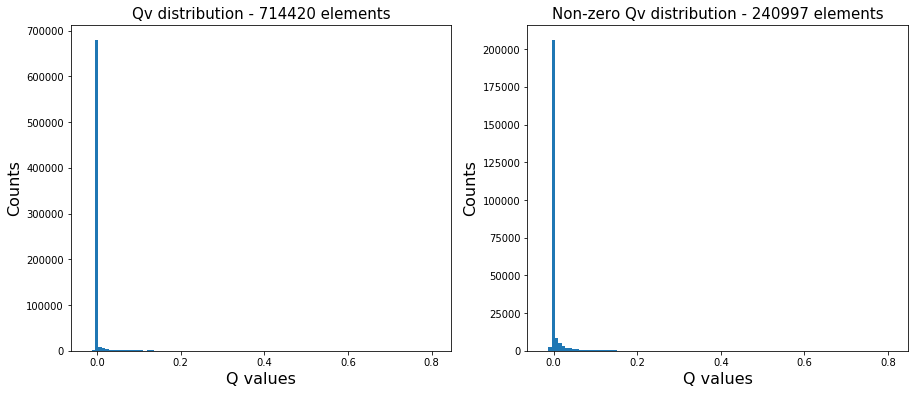

In [9]:
q_flat = q_values.flatten()
q_nonzero = q_flat[q_flat!=0]

plt.figure(figsize=(15,6))

plt.subplot(121)
n, bins, _ = plt.hist(q_flat, bins=100)
plt.title("Qv distribution - %d elements"%len(q_flat), fontsize=15)
plt.xlabel("Q values", fontsize=16)
plt.ylabel("Counts", fontsize=16)

plt.subplot(122)
n, bins, _ = plt.hist(q_nonzero, bins=100)
plt.title("Non-zero Qv distribution - %d elements"%len(q_nonzero), fontsize=15)
plt.xlabel("Q values", fontsize=16)
plt.ylabel("Counts", fontsize=16)

plt.show()

Now the particular Q-values that we are using are the result of a training of 200 epochs of 10 batches of 400 turns each, for a total of 800.000 moves, but it turns out that they explored only 45848 different action-state pairs (some elements were probably different berofe quantization, but this is not the point). 
We can define a measure, that we call novelty, as the ratio the states (we call them states instead of action-state pairs for a shorter notatio) explored and the moves made:
$$novelty = \frac{non~zero~ states}{tot. moves} = 0.0573 = 5.73 \%$$

A naive approach would suggest that we should train for the total number of states divided by the novelty factor to explore all the states, but of course the novelty is not a constant, but it is roughly a decreasing function of the number of moves that we have already done (e.g. for the first move the novelty is 1). 

For sure this means that more training will be useful, but it is also true that as the novelty decreases also the probability of making an error because we do not know how to evaluate a move. In general with such a high-dimensional space the only way to have an estimate of that probability is to measure it during training and then interpolate the function to make predictions.

### State values maps

Another thing that we can try to visualize is how good a spatial position is, given that we have a certain amount of cargo on board.

In [10]:
values = q_values.max(axis=1) # take the best possible action given the state -> state value
HD_shape = (MAP_SIZE**2,)+tuple([3 for i in range(6)]) + (4,)
print("High-dimensional shape of the state values: ", HD_shape)
values_HD = values.reshape(HD_shape)
# now spit the cargo dimension in 3 different sub-arrays
low_cargo = values_HD[:,0,...]
medium_cargo = values_HD[:,1,...]
high_cargo = values_HD[:,2,...]

High-dimensional shape of the state values:  (49, 3, 3, 3, 3, 3, 3, 4)


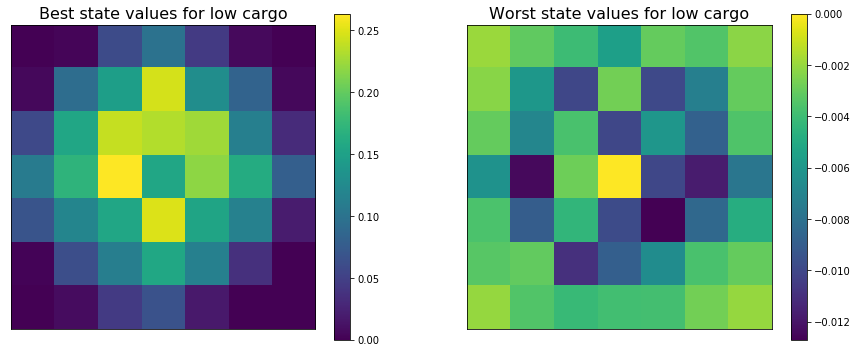

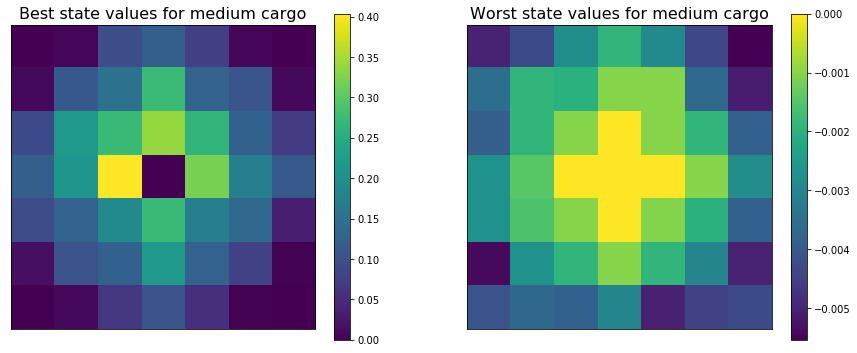

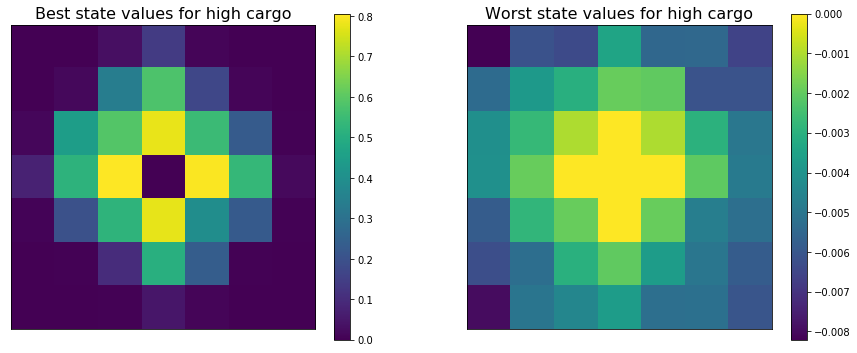

In [11]:
low_cargo_max = low_cargo.reshape(49,-1).max(axis=1).reshape(7,7)
low_cargo_min = low_cargo.reshape(49,-1).min(axis=1).reshape(7,7)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.imshow(low_cargo_max)
plt.xticks([])
plt.yticks([])
plt.title("Best state values for low cargo", fontsize=16)
plt.colorbar()

plt.subplot(122)
plt.imshow(low_cargo_min)
plt.xticks([])
plt.yticks([])
plt.title("Worst state values for low cargo", fontsize=16)
plt.colorbar()

plt.show()

medium_cargo_max = medium_cargo.reshape(49,-1).max(axis=1).reshape(7,7)
medium_cargo_min = medium_cargo.reshape(49,-1).min(axis=1).reshape(7,7)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.imshow(medium_cargo_max)
plt.xticks([])
plt.yticks([])
plt.title("Best state values for medium cargo", fontsize=16)
plt.colorbar()

plt.subplot(122)
plt.imshow(medium_cargo_min)
plt.xticks([])
plt.yticks([])
plt.title("Worst state values for medium cargo", fontsize=16)
plt.colorbar()

plt.show()

high_cargo_max = high_cargo.reshape(49,-1).max(axis=1).reshape(7,7)
high_cargo_min = high_cargo.reshape(49,-1).min(axis=1).reshape(7,7)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.imshow(high_cargo_max)
plt.xticks([])
plt.yticks([])
plt.title("Best state values for high cargo", fontsize=16)
plt.colorbar()

plt.subplot(122)
plt.imshow(high_cargo_min)
plt.xticks([])
plt.yticks([])
plt.title("Worst state values for high cargo", fontsize=16)
plt.colorbar()

plt.show()

These plots contain a lot of information:
1. Best states for each level of cargo are learned in a more symmetric way than the worse ones; this is because they are choosen more times, hence their estimates are more reliable.
2. For medium and high levels of cargo the shipyard position has value zero, whereas for the low level it is greater than zero. This is because the ship can never have cargo when is in the shipyard position (it is automatically deposited). As we have seen with the shipyard passages metric, this is not a problem, because the ship just needs to learn that the action of going to the shipyard is good, and this is confirmed by the fact that the highest values are in the proximity of the shipyard.

### Is Halite direction needed?

If you remember the `h_dir` variable encodes the direction in which there is the 3x3 area with the higher amount of halite. We would like to know if this is a good indicator to predict the best action to choose.

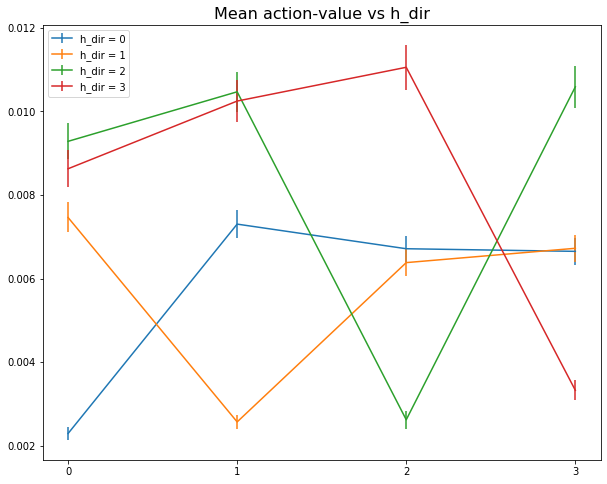

In [21]:
q_cardinals = q_values[:,1:] # remove a=0 subset of moves
HD_shape2 = (MAP_SIZE**2,)+tuple([3 for i in range(6)]) + (4,4)
q_HD = q_cardinals.reshape(HD_shape2)
plt.figure(figsize=(10,8))
for i in range(4):
    q_hdir = q_HD[...,i].reshape(-1,4) # select h_dir = i, then reshape as a matrix (s',a)
    #nonzero = np.count_nonzero(q_hdir0, axis=0)
    #q_mean0 = q_hdir0.sum(axis=0)/nonzero # mean over non-zero elements
    # compute standard deviation of non zero elements
    q_mean = []
    q_std = []
    for j in range(4):
        x = q_hdir[:,j]
        x_filtered = x[x!=0]
        mean = x_filtered.mean()
        std = x_filtered.std()/np.sqrt(len(x_filtered)) #deviation of the mean
        q_mean.append(mean)
        q_std.append(std)
    plt.errorbar(np.arange(4), q_mean, yerr = q_std, label='h_dir = '+str(i))
plt.legend()
plt.xticks([0,1,2,3])
plt.title("Mean action-value vs h_dir", fontsize=16)
plt.show()

As we can see there is a correlation between the mean value of a given action for different halite directions, but it is quite puzzling the fact that in general it is negatively correlated with the mean Q-value (that is, acting accordingly to the h_dir results in worse Q-values on average). A possible explanation is that usually the richest direction is never the one towards the shipyard, whereas the highest Q-values are always obtained moving towards the shipyard. 

To see more accurately if h_dir is useful, we should look at the typical situation for which that information was encoded, that is when the ship needs to collect resources (hence low cargo) but all around it there is low halite.
This could be typical of the final turns.

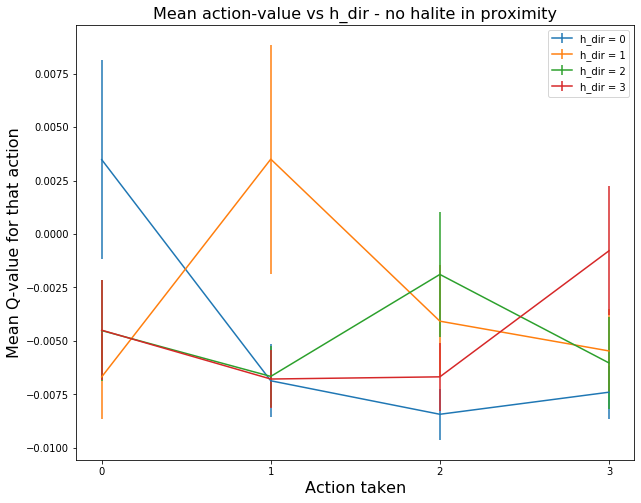

In [37]:
q_cardinals = q_values[:,1:] # remove a=0 subset of moves
HD_shape2 = (MAP_SIZE**2,)+tuple([3 for i in range(6)]) + (4,4)
q_HD = q_cardinals.reshape(HD_shape2)
plt.figure(figsize=(10,8))
for i in range(4):
    q_hdir0 = q_HD[:,0,0,0,0,0,0,i].reshape(-1,4) # select cargo=0, h_dir = i, then reshape as a matrix (s',a)
    q_mean = []
    q_std = []
    for j in range(4):
        x = q_hdir0[:,j]
        x_filtered = x[x!=0]
        mean = x_filtered.mean()
        std = x_filtered.std()/np.sqrt(len(x_filtered)) #deviation of the mean
        q_mean.append(mean)
        q_std.append(std)
    plt.errorbar(np.arange(4), q_mean, yerr = q_std, label='h_dir = '+str(i))
plt.legend()
plt.xticks([0,1,2,3])
plt.title("Mean action-value vs h_dir - no halite in proximity", fontsize=16)
plt.xlabel("Action taken", fontsize=16)
plt.ylabel("Mean Q-value for that action", fontsize=16)
plt.show()

In this case we can actually see that, all other things being equal, it is on average convenient to move towards the direction with the richest halite (for each curve the maximum is at the direction corresponding to the halite direction).

At the same time we can see that h_dir is completely ininfluent if we take all adjacent cells to zero except one direction. For example in the next plot we search for states that have the cell south to the ship with a higher value than the other ones and we find a peak for the action that goes toward the richest cell. 

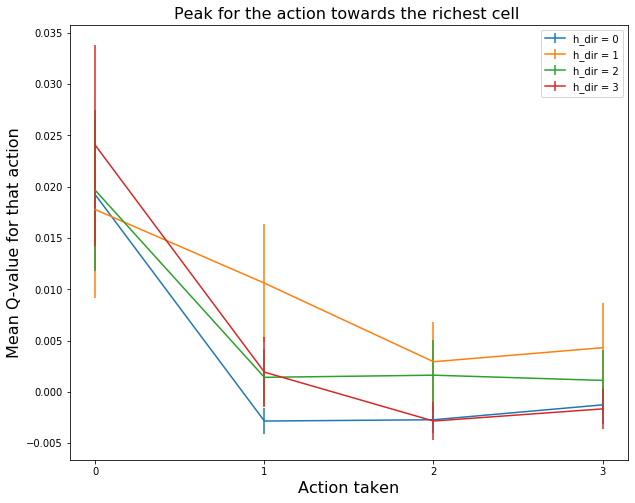

In [36]:
q_cardinals = q_values[:,1:] # remove a=0 subset of moves
HD_shape2 = (MAP_SIZE**2,)+tuple([3 for i in range(6)]) + (4,4)
q_HD = q_cardinals.reshape(HD_shape2)
plt.figure(figsize=(10,8))
for i in range(4):
    q_hdir0 = q_HD[:,0,0,1,0,0,0,i].reshape(-1,4) # select cargo=0, h_dir = i, then reshape as a matrix (s',a)
    q_mean = []
    q_std = []
    for j in range(4):
        x = q_hdir0[:,j]
        x_filtered = x[x!=0]
        mean = x_filtered.mean()
        std = x_filtered.std()/np.sqrt(len(x_filtered)) #deviation of the mean
        q_mean.append(mean)
        q_std.append(std)
    plt.errorbar(np.arange(4), q_mean, yerr = q_std, label='h_dir = '+str(i))
plt.legend()
plt.xticks([0,1,2,3])
plt.title("Peak for the action towards the richest cell ", fontsize=16)
plt.xlabel("Action taken", fontsize=16)
plt.ylabel("Mean Q-value for that action", fontsize=16)
plt.show()

# Taking home messages

In this tutorial we have seen three different methods to visualize what our agent is learning. 

* The first one was to show some average metrics performances during training, so that we can see how the training is going.

* The second one is to render an episode in a videogame style, that is the most intuitive visualization and can also support some meta-information encoding through colors and writings.

* The third one is to unpack the Q-values matrix in order to recover its high dimensional version and then select particular conditions that can be thought as hyperplanes untill we reduce the dimension enough to be visualized.

In the next tutorial we will address what by now you should have noticed as the major problem of the agent trained so far, that is that its performance is suboptimal. Stay tuned!